# Special topics

This notebook contains some special topics and plots requested internally at Argovis. Public consumers should focus on our educational notebooks, starting with [Intro to Argovis](https://github.com/argovis/demo_notebooks/blob/main/Intro_to_Argovis.ipynb).

In [14]:
from argovisHelpers import helpers as avh
import datetime, pandas, matplotlib, scipy, numpy
import matplotlib.pyplot as plt
import helpers
import numpy as np

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY=''

In [7]:
# get some profiles

#gulf_region = [[-95.62500000000001,27.237700025057197],[-85.51757812500001,27.938769379601297],[-85.166015625,23.506239070955658],[-95.62500000000001,21.88460897800666],[-95.62500000000001,27.237700025057197]]
# argo = {
#     'startDate': '2020-01-01T00:00:00Z',
#     'endDate': '2020-01-02T00:00:00Z',
#     'polygon': gulf_region,
#     'data': 'temperature,salinity'
# }
pac_region = [[-155,-1.5],[-155,-30],[-145,-30],[-145,-1.5],[-155,-1.5]]
argo = {
    'startDate': '2022-12-30T00:00:00Z',
    'endDate': '2023-01-13T00:00:00Z',
    'polygon': pac_region,
    'data': 'temperature,salinity'
}

floats = avh.query('argo', options=argo, apikey=API_KEY, apiroot=API_ROOT)

In [8]:
# only makes sense for profiles that have levels spanning the region of interest

shallow = 5
deep = 2000

profiles = [f for f in floats if 
                f['data'][f['data_info'][0].index('pressure')][0] < shallow and 
                f['data'][f['data_info'][0].index('pressure')][-1] > deep]

In [9]:
def interpolate_profile(raw, variable, levels):
    # raw: a single argovis profile as returned from the API, including a data_info key
    # variable: anything found in data_info[0] in the provided profile; the variable to interpolate
    # levels: the standard levels to interp to.
    
    # extract pressure and the variable to interpolate
    var_idx = raw['data_info'][0].index(variable)
    pressure_idx = raw['data_info'][0].index('pressure')
    var = raw['data'][var_idx]
    pressure = raw['data'][pressure_idx]
    
    return list(scipy.interpolate.pchip_interpolate(pressure, var, levels))

In [15]:
# interpolate temperature and salinity

levels = list(range(shallow,deep,5))

interpolated_temperatures = np.array([interpolate_profile(f, 'temperature', levels) for f in profiles])
interpolated_salinity = np.array([interpolate_profile(f, 'salinity', levels) for f in profiles])

In [16]:
# transpose and cast to various rectangular forms as desired

numpy.shape(interpolated_temperatures)

(19, 399)

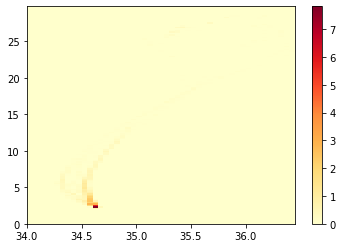

In [38]:
plt.hist2d(interpolated_salinity.flatten(),interpolated_temperatures.flatten(),density=True,
           bins=[np.arange(34,36.5,.05),np.arange(0,30,.2)],cmap='YlOrRd') #hot_r
plt.colorbar()